In [ ]:
import importlib
import json
import os
from collections import defaultdict
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from fusion_bench.utils.json import load_from_json

from plot_utils import TASK_TO_LABEL_MAPPING
from plot_utils import v2_colors as COLORS

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

PROJECT_ROOT = Path(
    os.path.abspath(
        os.path.join(importlib.import_module("fusion_bench").__path__[0], "..")
    )
)

In [3]:
def gather_single_model_report(base_model: str):
    result_dir = PROJECT_ROOT / "outputs" / "single_task_evaluation" / base_model
    reports = defaultdict(list)
    model_names = os.listdir(result_dir)
    for model_name in model_names:
        report_path = result_dir / model_name / "report.json"
        data = load_from_json(report_path)
        for task_name, task_report in data.items():
            if task_name != "model_info" and task_name != "average":
                reports["model_name"].append(model_name)
                reports["task_name"].append(task_name)
                reports["accuracy"].append(task_report["accuracy"])
                reports["loss"].append(task_report["loss"])
    return pd.DataFrame(reports)

In [4]:
def get_pretrained_expert_accuracy(df: pd.DataFrame):
    tasks = df["task_name"].unique()
    pretrained_accuracy = {}
    expert_accuracy = {}
    pretrained_data = df[df["model_name"] == "pretrained"]
    for task in tasks:
        pretrained_acc = pretrained_data[pretrained_data["task_name"] == task][
            "accuracy"
        ]
        assert len(pretrained_acc) == 1
        pretrained_accuracy[task] = float(pretrained_acc.values[0])

        expert_data = df[df["model_name"] == task]
        expert_acc = expert_data[expert_data["task_name"] == task]["accuracy"]
        assert len(expert_acc) == 1
        expert_accuracy[task] = float(expert_acc.values[0])

    return pretrained_accuracy, expert_accuracy

In [5]:
def plot_radar_chart(df, ax, colors=None, plot_legend=False):
    """
    Create a beautiful radar chart.

    Parameters:
    - df: DataFrame containing the data
    - ax: Matplotlib axis object
    - colors: Optional list of colors for different models
    """
    # Get the task names (excluding the model_name column)
    categories = [col for col in df.columns if col != "model_name"]
    num_vars = len(categories)

    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the circle

    # Set default colors if not provided
    if colors is None:
        colors = plt.cm.viridis(np.linspace(0, 1, len(df)))

    # Style improvements
    ax.grid(
        True,
        linestyle="-",
    )

    # Draw axis lines
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw the outer circle more prominently
    ax.spines["polar"].set_visible(True)
    ax.spines["polar"].set_linewidth(1)

    # Plot data
    for idx, (_, row) in enumerate(df.iterrows()):
        values = row[categories].values.flatten().tolist()
        values += values[:1]

        # Plot with enhanced styling
        ax.plot(
            angles,
            values,
            "o-",
            linewidth=1.5,
            label=row["model_name"],
            color=colors[idx],
            markersize=2,
        )

        ax.fill(angles, values, color=colors[idx], alpha=0.15)

    # Customize axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, ha="center", va="center")
    # Rotate angular labels for better readability
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        if angle in (0, np.pi):
            label.set_horizontalalignment("center")
        elif 0 < angle < np.pi:
            label.set_horizontalalignment("left")
        else:
            label.set_horizontalalignment("right")
    # Customize y-axis
    ax.set_ylim(0, 1)  # Add some padding
    ax.set_rlabel_position(0)  # Move radial labels away from plotted line

    # Add legend with custom styling
    if plot_legend:
        legend = ax.legend(
            loc="upper right",
            bbox_to_anchor=(1.3, 1.1),
            frameon=True,
        )
        legend.get_frame().set_alpha(0.9)

    return ax

In [ ]:
for base_model in ["vit-b-32", "vit-b-16", "vit-l-14"]:
    df = gather_single_model_report(base_model)
    df.to_csv(f"results/{base_model}.csv", index=False)

    pretrained_accuracy, expert_accuracy = get_pretrained_expert_accuracy(df)
    data = defaultdict(list)
    data["model_name"].append("pretrained")
    for task in pretrained_accuracy.keys():
        data[task].append(pretrained_accuracy[task])
    data["model_name"].append("finetuned")
    for task in expert_accuracy.keys():
        data[task].append(expert_accuracy[task])
    df = pd.DataFrame(data)
    print(f"{base_model} results:")
    display(df)
    df.to_csv(f"results/{base_model}.csv", index=False)

vit-b-32 results:


,model_name,mnist,fer2013,cifar10,stl10,oxford_flowers102,emnist_letters,sun397,stanford-cars,resisc45,...,svhn,gtsrb,dtd,pcam,oxford-iiit-pet,cifar100,food101,fashion_mnist,kmnist,rendered-sst2
0,pretrained,0.4826,0.412510,0.8983,0.97125,0.664498,0.119760,0.631788,0.595821,0.602698,...,0.316265,0.325257,0.442021,0.606354,0.833197,0.6372,0.823644,0.6301,0.0995,0.586491
1,finetuned,0.9958,0.716077,0.9760,0.97550,0.885510,0.956154,0.748615,0.785226,0.951429,...,0.972687,0.989074,0.796808,0.879608,0.924503,0.8838,0.884079,0.9475,0.9823,0.712795


vit-b-16 results:


,model_name,mnist,fer2013,cifar10,stl10,oxford_flowers102,emnist_letters,sun397,stanford-cars,resisc45,...,svhn,gtsrb,dtd,pcam,oxford-iiit-pet,cifar100,food101,fashion_mnist,kmnist,rendered-sst2
0,pretrained,0.5173,0.463918,0.9077,0.9825,0.713124,0.124375,0.655365,0.646810,0.663810,...,0.519899,0.434521,0.450000,0.540222,0.884437,0.6633,0.870139,0.6730,0.1121,0.605711
1,finetuned,0.9970,0.727640,0.9828,0.9815,0.948772,0.952837,0.789219,0.858973,0.965556,...,0.976068,0.989865,0.823404,0.905548,0.944944,0.8878,0.918653,0.9453,0.9810,0.757276


vit-l-14 results:


,model_name,mnist,fer2013,cifar10,stl10,oxford_flowers102,emnist_letters,sun397,stanford-cars,resisc45,...,svhn,gtsrb,dtd,pcam,oxford-iiit-pet,cifar100,food101,fashion_mnist,kmnist,rendered-sst2
0,pretrained,0.7631,0.499582,0.9559,0.993625,0.792487,0.123413,0.682217,0.778634,0.713333,...,0.584319,0.505226,0.555319,0.512054,0.932134,0.7505,0.911802,0.6696,0.0971,0.689182
1,finetuned,0.9976,0.759264,0.9913,0.992250,0.976744,0.954279,0.827607,0.927745,0.973810,...,0.979218,0.992399,0.854787,0.911316,0.957482,0.9300,0.947723,0.9528,0.9830,0.804503


vit-b-32 results:


,model_name,mnist,fer2013,cifar10,stl10,oxford_flowers102,emnist_letters,sun397,stanford-cars,resisc45,...,svhn,gtsrb,dtd,pcam,oxford-iiit-pet,cifar100,food101,fashion_mnist,kmnist,rendered-sst2
0,pretrained,0.4826,0.412510,0.8983,0.97125,0.664498,0.119760,0.631788,0.595821,0.602698,...,0.316265,0.325257,0.442021,0.606354,0.833197,0.6372,0.823644,0.6301,0.0995,0.586491
1,finetuned,0.9958,0.716077,0.9760,0.97550,0.885510,0.956154,0.748615,0.785226,0.951429,...,0.972687,0.989074,0.796808,0.879608,0.924503,0.8838,0.884079,0.9475,0.9823,0.712795


(4.5, 4.5)


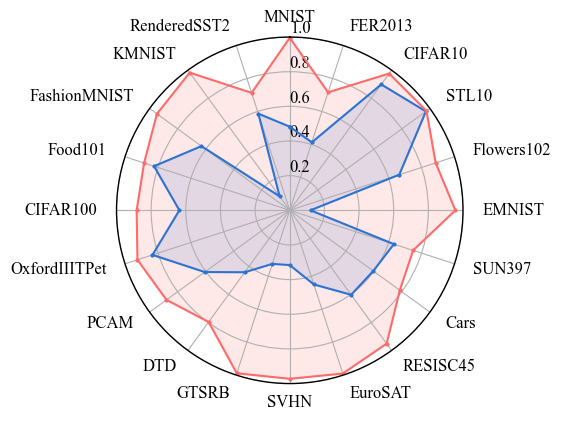

vit-b-16 results:


,model_name,mnist,fer2013,cifar10,stl10,oxford_flowers102,emnist_letters,sun397,stanford-cars,resisc45,...,svhn,gtsrb,dtd,pcam,oxford-iiit-pet,cifar100,food101,fashion_mnist,kmnist,rendered-sst2
0,pretrained,0.5173,0.463918,0.9077,0.9825,0.713124,0.124375,0.655365,0.646810,0.663810,...,0.519899,0.434521,0.450000,0.540222,0.884437,0.6633,0.870139,0.6730,0.1121,0.605711
1,finetuned,0.9970,0.727640,0.9828,0.9815,0.948772,0.952837,0.789219,0.858973,0.965556,...,0.976068,0.989865,0.823404,0.905548,0.944944,0.8878,0.918653,0.9453,0.9810,0.757276


(4.5, 4.5)


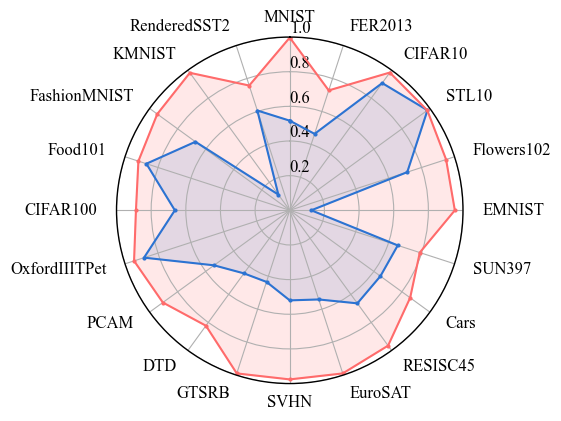

vit-l-14 results:


,model_name,mnist,fer2013,cifar10,stl10,oxford_flowers102,emnist_letters,sun397,stanford-cars,resisc45,...,svhn,gtsrb,dtd,pcam,oxford-iiit-pet,cifar100,food101,fashion_mnist,kmnist,rendered-sst2
0,pretrained,0.7631,0.499582,0.9559,0.993625,0.792487,0.123413,0.682217,0.778634,0.713333,...,0.584319,0.505226,0.555319,0.512054,0.932134,0.7505,0.911802,0.6696,0.0971,0.689182
1,finetuned,0.9976,0.759264,0.9913,0.992250,0.976744,0.954279,0.827607,0.927745,0.973810,...,0.979218,0.992399,0.854787,0.911316,0.957482,0.9300,0.947723,0.9528,0.9830,0.804503


(6, 4.5)


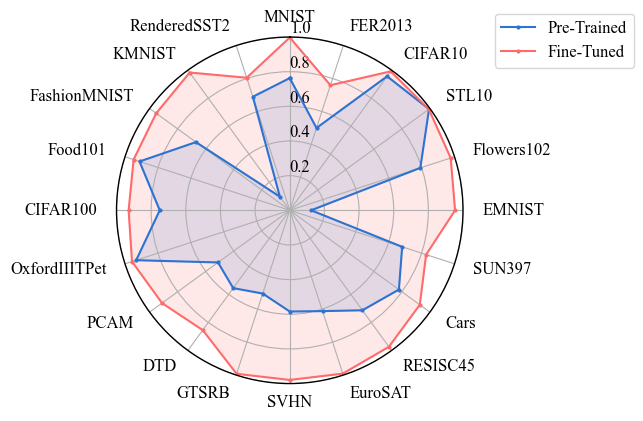

In [7]:
plt.rcParams.update({"font.size": 12})

for base_model in ["vit-b-32", "vit-b-16", "vit-l-14"]:
    print(f"{base_model} results:")
    df = pd.read_csv(f"results/{base_model}.csv")
    display(df)
    df = df.rename(columns=TASK_TO_LABEL_MAPPING)
    # plot radar chart
    figsize = (4.5, 4.5) if base_model != "vit-l-14" else (6, 4.5)
    print(figsize)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="polar")
    plot_radar_chart(
        df, ax, colors=COLORS, plot_legend=False if base_model == "vit-l-14" else False
    )

    if base_model == "vit-l-14":
        # Creating the legend
        legend = ax.legend(
            loc="upper right",
            bbox_to_anchor=(1.1, 0.95),
            bbox_transform=fig.transFigure,
            frameon=True,
        )
        # Renaming the legend labels
        legend.get_texts()[0].set_text("Pre-Trained")
        legend.get_texts()[1].set_text("Fine-Tuned")

    plt.savefig(
        f"images/single_model_{base_model}.pdf",
        bbox_inches="tight",
    )
    plt.show()

In [28]:
TA8 = [
    "sun397",
    "stanford-cars",
    "resisc45",
    "eurosat",
    "svhn",
    "gtsrb",
    "mnist",
    "dtd",
]
TALL14 = TA8 + [
    "oxford_flowers102",
    "pcam",
    "fer2013",
    "oxford-iiit-pet",
    "stl10",
    "cifar100",
]
TALL20 = TALL14 + [
    "cifar10",
    "food101",
    "fashion_mnist",
    "emnist_letters",
    "kmnist",
    "rendered-sst2",
]
for base_model in ["vit-b-32", "vit-b-16", "vit-l-14"]:
    print(f"\n{base_model} results:\n")
    df = pd.read_csv(f"results/{base_model}.csv")
    pretrained_df = df[df["model_name"] == "pretrained"]
    print("=== pretrained results:")
    print("8:", pretrained_df[TA8].mean(axis=1))
    print("14:", pretrained_df[TALL14].mean(axis=1))
    print("20:", pretrained_df[TALL20].mean(axis=1))
    finetuned_df = df[df["model_name"] == "finetuned"]
    print("=== finetuned results:")
    print("8:", finetuned_df[TA8].mean(axis=1))
    print("14:", finetuned_df[TALL14].mean(axis=1))
    print("20:", finetuned_df[TALL20].mean(axis=1))


vit-b-32 results:

=== pretrained results:
8: 0    0.480806
dtype: float64
14: 0    0.56939
dtype: float64
20: 0    0.556463
dtype: float64
=== finetuned results:
8: 1    0.903797
dtype: float64
14: 1    0.892527
dtype: float64
20: 1    0.89771
dtype: float64

vit-b-16 results:

=== pretrained results:
8: 0    0.553602
dtype: float64
14: 0    0.619737
dtype: float64
20: 0    0.598467
dtype: float64
=== finetuned results:
8: 1    0.923761
dtype: float64
14: 1    0.913306
dtype: float64
20: 1    0.916208
dtype: float64

vit-l-14 results:

=== pretrained results:
8: 0    0.64925
dtype: float64
14: 0    0.691027
dtype: float64
20: 0    0.656069
dtype: float64
=== finetuned results:
8: 1    0.943035
dtype: float64
14: 1    0.933667
dtype: float64
20: 1    0.935247
dtype: float64
